In [218]:
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
from typing import List, Tuple, Annotated, Sequence, Literal
from typing_extensions import TypedDict
from IPython.display import Image, display
import psycopg2
import os
import json
import logging

load_dotenv()

OLLAMA_MODEL = "llama3.1:8b"
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD")
POSTGRES_USER = os.getenv("POSTGRES_USER")
POSTGRES_DATABASE = os.getenv("POSTGRES_DATABASE")

OLLAMA_BASE_URL = "100.110.219.100:11434"

In [219]:
llm = ChatOllama(model=OLLAMA_MODEL, temperature=0, base_url=OLLAMA_BASE_URL)
llm_json = ChatOllama(model=OLLAMA_MODEL, temperature=0, format="json", base_url=OLLAMA_BASE_URL)

In [252]:
# Router

ROUTER_INSTRUCTIONS = '''You are an expert at determining whether a user question requires access to a database from a smartphone shop. 

The database schema is as follows:
- id (int): The unique identifier of the smartphone. You will not use this.
- brand (str): The brand of the smartphone, (eg. 'Apple', 'Google', 'Samsung'...)
- model (str): The model of the smartphone (eg. 'iPhone 13 Pro Max', 'Galaxy S21 Ultra', 'Mi 13 Pro'...)
- price (int): The price of the smartphone in Singapore Dollars.
- stock_status (str): The stock status of the smartphone ('In Stock', 'Out of Stock')

For questions related to a smartphone's price or availibility, you should accept the user query since it requires information from the database. For unknown brands or models, you should also approve the query since it may require database access. For all other questions that do not require database access, please reject the query.

Return JSON with a single key user_query, that is 'accept' or 'reject' depending on whether the question requires database access.'''

question = [HumanMessage(content="Hello, what is the price of the iphone 13 mini?")]

test_router_response = llm_json.invoke([SystemMessage(content=ROUTER_INSTRUCTIONS)] + question)

json.loads(test_router_response.content)

{'user_query': 'accept'}

In [253]:
@tool
def executePostgreSQLQuery(query: str) -> List[Tuple[int, str, str, int, str]]:
    '''Executes a PostgreSQL query and returns the result as a list of tuples. Please only query the table "smartphones".
    
    Args:
        query (str): The PostgreSQL query to be executed.
        
    Returns:
        result (List[Tuple[int, str, str, int, str]]): The result of the query, a list of tuples (id, brand, model, price, stock_status).
    '''

    # Connect to database
    # print("executePostgreSQLQuery tool called!")
    conn = psycopg2.connect(database=POSTGRES_DATABASE, user=POSTGRES_USER, password=POSTGRES_PASSWORD, host="localhost", port="5432")
    # print("Database connected successfully.")
    with conn.cursor() as cursor:
        try:
            # print("Executing sql query...")
            cursor.execute(query)
            result = cursor.fetchall()
        except:
            # print("Error executing query.")
            conn.close()
            return
    # Close connection
    conn.close()
    if result:
        # print("Database query success")
        return result
    else:
        return "No results found."

In [254]:
# Database query

SQL_AGENT_INSTRUCTIONS = '''You are an agent designed to interact with a PostgreSQL database.

Given an input question, create a syntactically correct PostgreSQL query to run. Your query should always begin with "SELECT * FROM smartphones WHERE" and you can add any conditions you want. Note that all string comparisons should be match case-insensitive and enclosed within single quotes.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

The database schema is as follows:
- id (int): The unique identifier of the smartphone. You will not use this.
- brand (str): The brand of the smartphone, (eg. 'Apple', 'Google', 'Samsung'...)
- model (str): The model of the smartphone (eg. 'iPhone 13 Pro Max', 'Galaxy S21 Ultra', 'Mi 13 Pro'...)
- price (int): The price of the smartphone in Singapore Dollars.
- stock_status (str): The stock status of the smartphone ('In Stock', 'Out of Stock')
'''


question = [HumanMessage(content="Hello, what is the price of the iphone 13 mini?")]

llm_with_db = llm.bind_tools([executePostgreSQLQuery])

test_sql_agent_response = llm_with_db.invoke([SystemMessage(content=SQL_AGENT_INSTRUCTIONS)] + question)

tool_call_result = executePostgreSQLQuery.invoke(test_sql_agent_response.tool_calls[0]).content

tool_call_result

'[[10, "Apple", "iPhone 13 Mini", 999, "Out of Stock"]]'

In [255]:
test_sql_agent_response

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1:8b', 'created_at': '2025-03-17T07:40:44.7963767Z', 'done': True, 'done_reason': 'stop', 'total_duration': 427010995, 'load_duration': 27766612, 'prompt_eval_count': 457, 'prompt_eval_duration': 24000000, 'eval_count': 37, 'eval_duration': 374000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-3f1da5b1-b757-4fe6-afe9-a475c05fdf2c-0', tool_calls=[{'name': 'executePostgreSQLQuery', 'args': {'query': "SELECT * FROM smartphones WHERE brand = 'Apple' AND model = 'iPhone 13 Mini'"}, 'id': '0eea0b14-665b-4cbf-b107-5444accd1eca', 'type': 'tool_call'}], usage_metadata={'input_tokens': 457, 'output_tokens': 37, 'total_tokens': 494})

In [256]:
# Generate response

RAG_PROMPT = '''You are an assistant that helps to answer users' queries about smartphone pricing and availibility.
Here is the context to use to answer the question, a database query response that contains ONLY information about the requested smartphone(s) brand, model, price, and availibility. 
If the requested smartphone is not found in the database, please inform the user that you do not sell this model.
For all other specifications like storage, colour, etc. please inform the user that you do not have the information. 
Inform the user politely instead of giving incorrect data, suggesting alternative models instead. Offer suggestions if customers type incomplete or ambiguous queries (e.g., "Did you mean iPhone 13 Pro or iPhone 13 Mini?"):

{context} 

Here is the user's question:

{question}

Convey all information to the user.
Answer:'''

rag_prompt_formatted = RAG_PROMPT.format(context=tool_call_result, question=question)

test_generate_response = llm.invoke([HumanMessage(content=rag_prompt_formatted)])

print(test_generate_response.content)

We have an iPhone 13 Mini available in our database. The price for this model is $999. However, we currently do not have it in stock.

If you're interested in purchasing a similar device, I can suggest considering other models such as the iPhone 13 or checking back with us when new stock arrives.


In [257]:
# Grader

GRADER_INSTRUCTIONS = '''You are an expert grader that will be provided with data from a smartphone store's database and another LLM's output. Your role
is to spot hallucinated outputs by an LLM.
If the database contains information that matches the LLM output, grade it as 'yes'. If there are no matching results, 'No results found' will be returned by the database.
This means that the smartphone that the user has requested is not legitimate/not present in the smartphones' database.

Example:
{'grader_score': 'no',
 'justification': "The database does not contain any information about the price of the iPhone 13 Pro, so it's likely that the LLM made something up."}

Return JSON with two keys; grader_score: either 'yes' or 'no' to indicate whether the user's question can be answered with the data provided, and
justification: explain your rationale for grader_score.'''

GRADER_PROMPT = '''Here is the data provided: \n\n {data} \n\n Here is the LLM output: \n\n {llm_output}'''


grader_prompt_formatted = GRADER_PROMPT.format(data=tool_call_result, llm_output=test_generate_response.content)

test_grader_response = llm_json.invoke([SystemMessage(content=GRADER_INSTRUCTIONS)] + [HumanMessage(content=grader_prompt_formatted)])

json.loads(test_grader_response.content)

{'grader_score': 'yes',
 'justification': "The database contains information about the iPhone 13 Mini, including its price and availability status, which matches the LLM's output."}

In [229]:
rag_prompt_formatted = RAG_PROMPT.format(context=[tool_call_result + test_grader_response.content], question=question)

test_generate_response = llm.invoke([HumanMessage(content=rag_prompt_formatted)])

print(test_generate_response.content)

I'm happy to help you with your query about the iPhone 13 Pro. Unfortunately, I don't have any information about this model in our database. We do not sell this specific model.

However, if you're interested in purchasing an iPhone, we have other models available. For example, we have the iPhone 12 series and the latest iPhone 14 series. Would you like me to suggest some alternative options?


In [190]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_result: List

In [ ]:
# Converting everything above into a function

# Edges

def grader(state) -> Literal["yes", "no"]:
    '''Determines whether the results from the database can answer the user's question. If not, suggest alternatives or inform the user that the information is not available.
    
    Args:
        state (State): The current state of the agent.
    
    Returns:
        str: A decision by the model for whether the user's question can be answered with the data provided.'''
    
    llm_json = ChatOllama(model=OLLAMA_MODEL, temperature=0, format="json", base_url=OLLAMA_BASE_URL)

    # Take the first message in the state to get the user question
    question = state["messages"][-1].content

    # Get the tool call result from the state
    tool_call_result = state["tool_call_result"]

    # Format the system prompt sent to the llm with context from the database and user question
    grader_prompt_formatted = GRADER_PROMPT.format(data=tool_call_result, question=question)

    grader_response = llm_json.invoke([SystemMessage(content=GRADER_INSTRUCTIONS)] + [HumanMessage(content=grader_prompt_formatted)])
    # print("Grading the results from the database...")
    grader_score = json.loads(grader_response.content)
    
    if grader_score.get("grader_score") == "yes":
        # print("The user's question can be answered with the data provided.")
        return "yes"
    else:
        # print("The user's question cannot be answered with the data provided.")
        return "no"

def router(state) -> Literal["accept", "reject"]:
    '''Determines whether the user query requires access to the database.
    
    Args:
        state (State): The current state of the agent.
    
    Returns:
        str: Either calls the sql_agent node or generates a response directly based on the user query.'''
    
    # Take the first message in the state to get the user question
    question = state["messages"][-1]

    # Get the AIResponse containing a JSON object to indicate whether database access is accepted or rejected
    router_response = llm_json.invoke([SystemMessage(content=ROUTER_INSTRUCTIONS)] + [question])
    # print("Processing user query...")
    user_query = json.loads(router_response.content)

    if user_query.get("user_query") == "accept":
        # print("The user's query requires access to the database.")
        return "accept"
    else:
        # print("The user's query does not require access to the database.")
        return "reject"

# Nodes
def sql_agent(state):
    '''Generate a SQL query based on the user question and executes it.
    
    Args:
        state (State): The current state of the agent.
        
    Returns:
        dict: The updated state with the tool call result appended to messages.'''

    llm = ChatOllama(model=OLLAMA_MODEL, temperature=0, base_url=OLLAMA_BASE_URL)

    # In this case, only one tool is present, so I am hardcoding it
    # state['tools'] = StructuredTool object
    llm_with_db = llm.bind_tools([executePostgreSQLQuery])

    # Take the first message in the state to get the user question
    question = state["messages"][-1]

    # The AIResponse containing the tool call and the sql query to be performed
    sql_agent_response = llm_with_db.invoke([SystemMessage(content=SQL_AGENT_INSTRUCTIONS)] + [question])
    
    # print("Generating SQL query to execute...")
    # Execute the sql query and return the result
    tool_call_result = executePostgreSQLQuery.invoke(sql_agent_response.tool_calls[0])
    # print(f"Executing SQL query: {sql_agent_response.tool_calls[0].get('args').get('query')} ")

    return {"tool_call_result": tool_call_result}

def generate_response(state):
    '''Generate response to user query based on the context and user question.
    
    Args:
        state (State): The current state of the agent.
        
    Returns:
        dict: The updated state with the final response to the user query.'''

    # Take the first message in the state to get the user question

    question = state["messages"][-1].content

    # Get the tool call result from the state
    tool_call_result = state["tool_call_result"]
    
    # Format the system prompt sent to the llm with context and user question
    rag_prompt_formatted = RAG_PROMPT.format(context=tool_call_result, question=question)

    generate_response = llm.invoke([HumanMessage(content=rag_prompt_formatted)])

    return {"messages": [generate_response]}


In [250]:
workflow = StateGraph(State)

workflow.add_node("sql_agent", sql_agent)
workflow.add_node("generate_response", generate_response)

workflow.set_conditional_entry_point(
    router,
    {
        "accept": "sql_agent",
        "reject": "generate_response"
    }
)

# should add like a max number of retries, if no go back to sql_agent
workflow.add_conditional_edges(
    "generate_response",
    grader,
    {
        "yes": END,
        "no": "generate_response"
    }
)

workflow.add_edge("sql_agent", "generate_response")

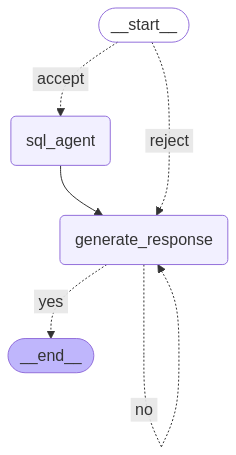

In [251]:
checkpointer = MemorySaver()

graph = workflow.compile(checkpointer=checkpointer)

display(Image(graph.get_graph().draw_mermaid_png()))

In [245]:
print(tool_call_result)

No results found.


In [246]:
import uuid
inputs = "Hello, what is the price of the iphone 13 pro?"

In [247]:
prompt = {
    "messages": [HumanMessage(content=inputs)],
    "tool_call_result": []
    }
config = {"configurable": {"thread_id": "12344"}}

buffer = []
tool_msg_received = False
async for output, _ in graph.astream(prompt, config, stream_mode="messages"):
    if not tool_msg_received:
        buffer.append(output)
        if isinstance(output, ToolMessage):
            tool_msg_received = True
            buffer.clear()
    else:
        # After the ToolMessage, print tokens directly.
        print(output.content, end='', flush=True)



Based on our database, we have found information about the iPhone 13 Pro. Here are the details you requested:

* Brand: Apple
* Model: iPhone 13 Pro
* Price: We currently have this model available for $999.

As for availability, we do have stock of the iPhone 13 Pro in our stores. However, please note that prices and availability may vary depending on your location and other factors.

Regarding storage and color options, I'm afraid we don't have that information readily available. If you're interested in purchasing this model, I recommend visiting our website or contacting one of our customer service representatives for more details.

If you'd like to consider alternative models, we also have the iPhone 13 Mini available at a lower price point ($699). Would you like me to provide more information on that option?

KeyError: 'llm_output'